Computing mask...
Computing correlation matrix...


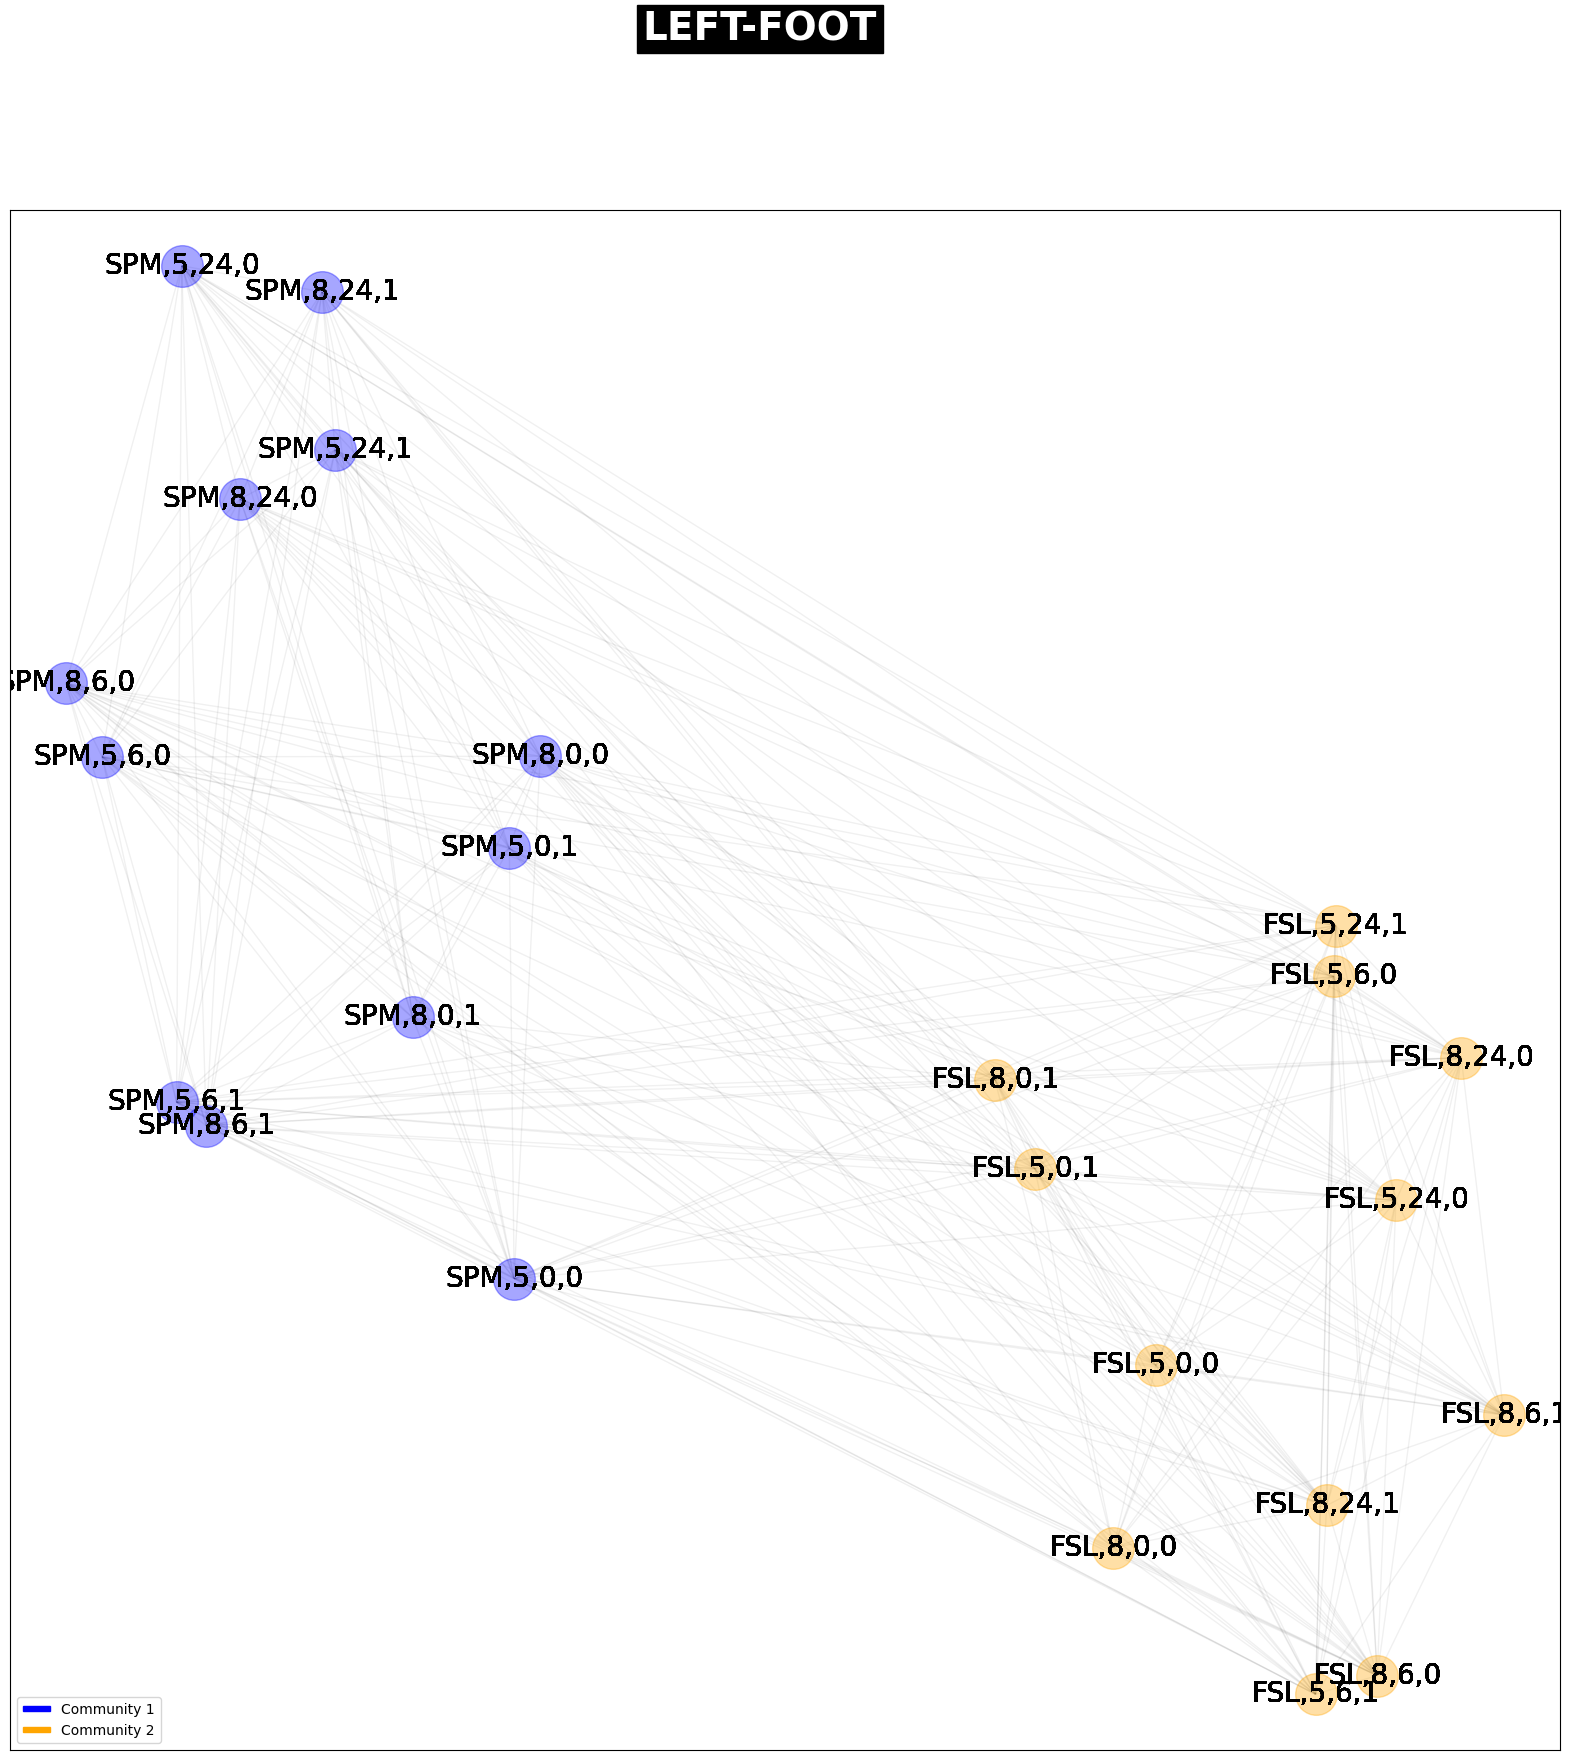

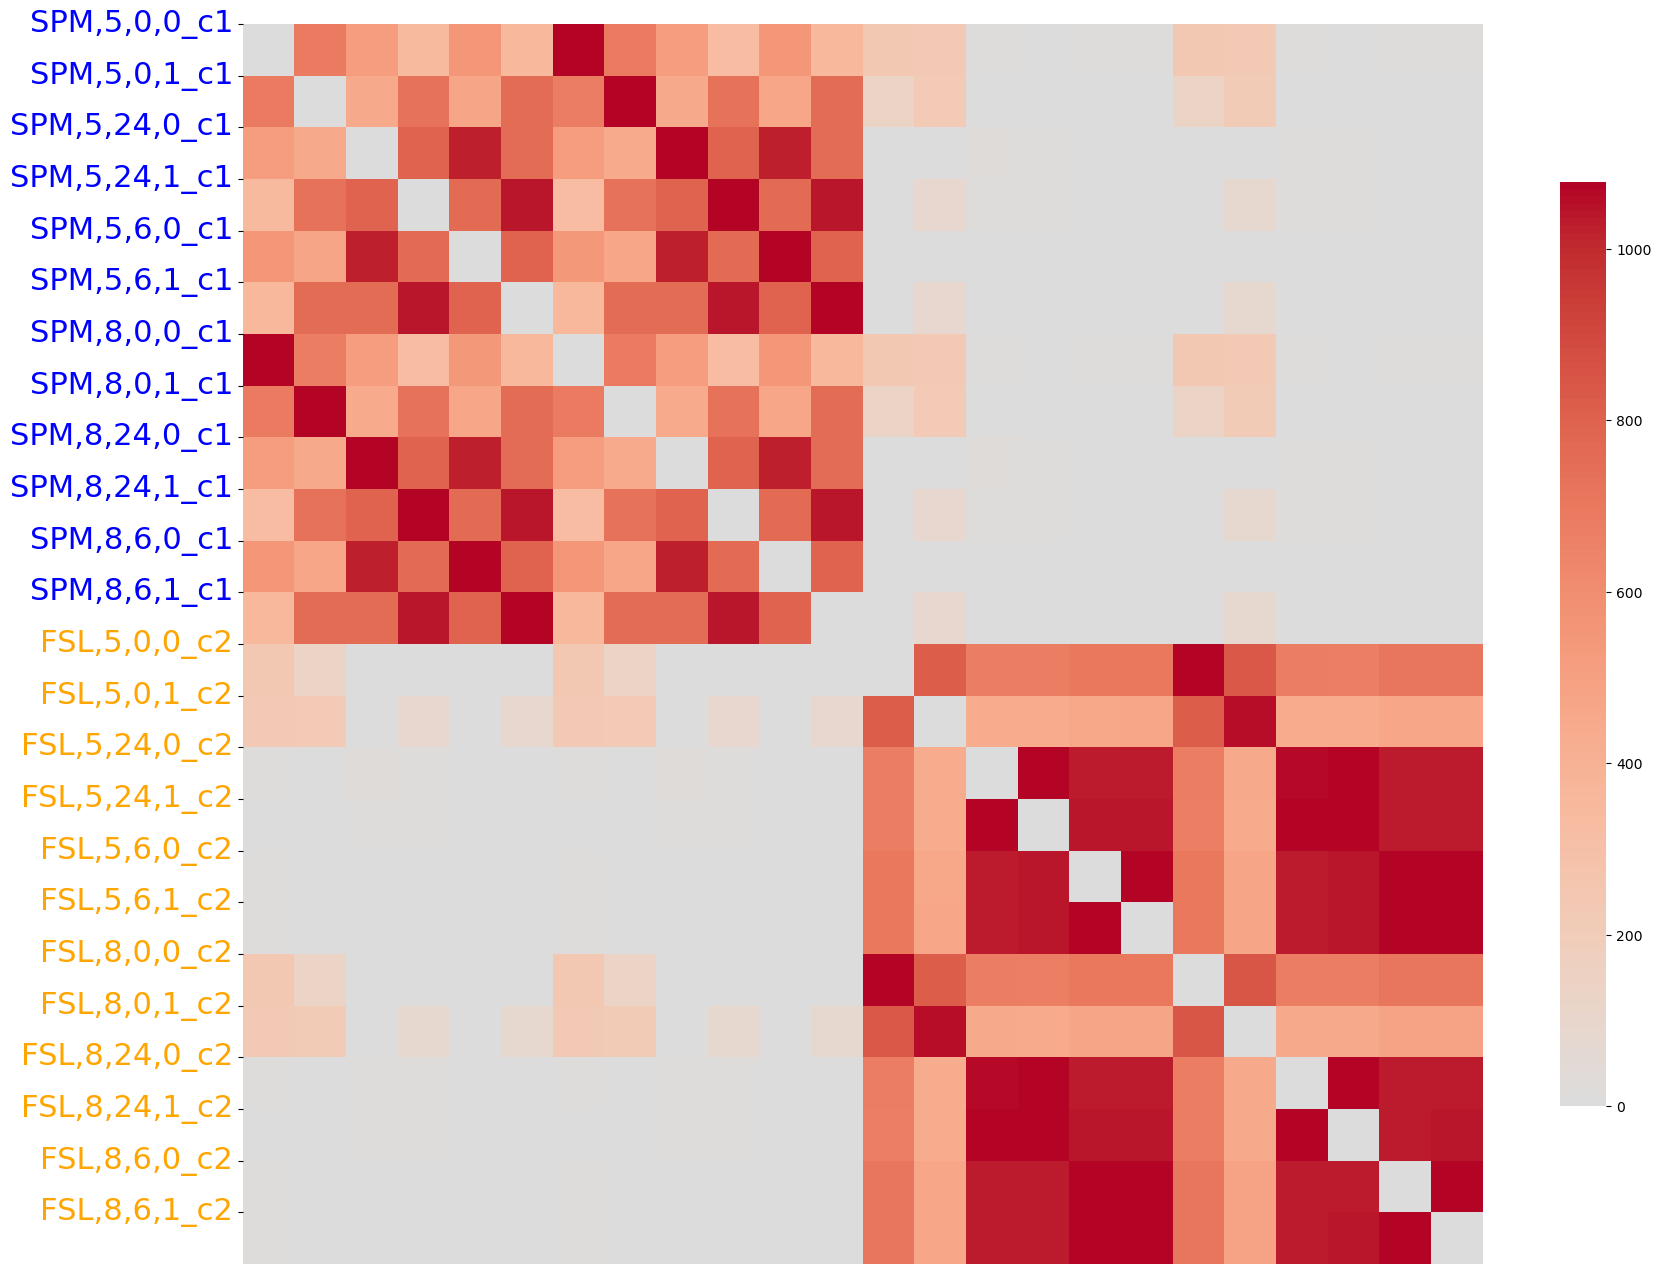

In [1]:
import louvain_matrix
louvain_matrix.main()

Computing mask...
Computing mean image...
Pipelines belonging to 0 : ['FSL,5,0,0', 'FSL,5,24,0', 'FSL,5,24,1', 'FSL,5,6,0', 'FSL,8,0,0', 'FSL,8,24,0', 'FSL,8,24,1', 'FSL,8,6,0']
Pipelines belonging to 1 : ['FSL,5,0,1', 'FSL,5,6,1', 'FSL,8,0,1', 'FSL,8,6,1']
Pipelines belonging to 2 : ['SPM,5,0,0', 'SPM,5,24,0', 'SPM,5,6,0', 'SPM,8,0,0', 'SPM,8,24,0', 'SPM,8,6,0']
Pipelines belonging to 3 : ['SPM,5,0,1', 'SPM,5,24,1', 'SPM,5,6,1', 'SPM,8,0,1', 'SPM,8,24,1', 'SPM,8,6,1']


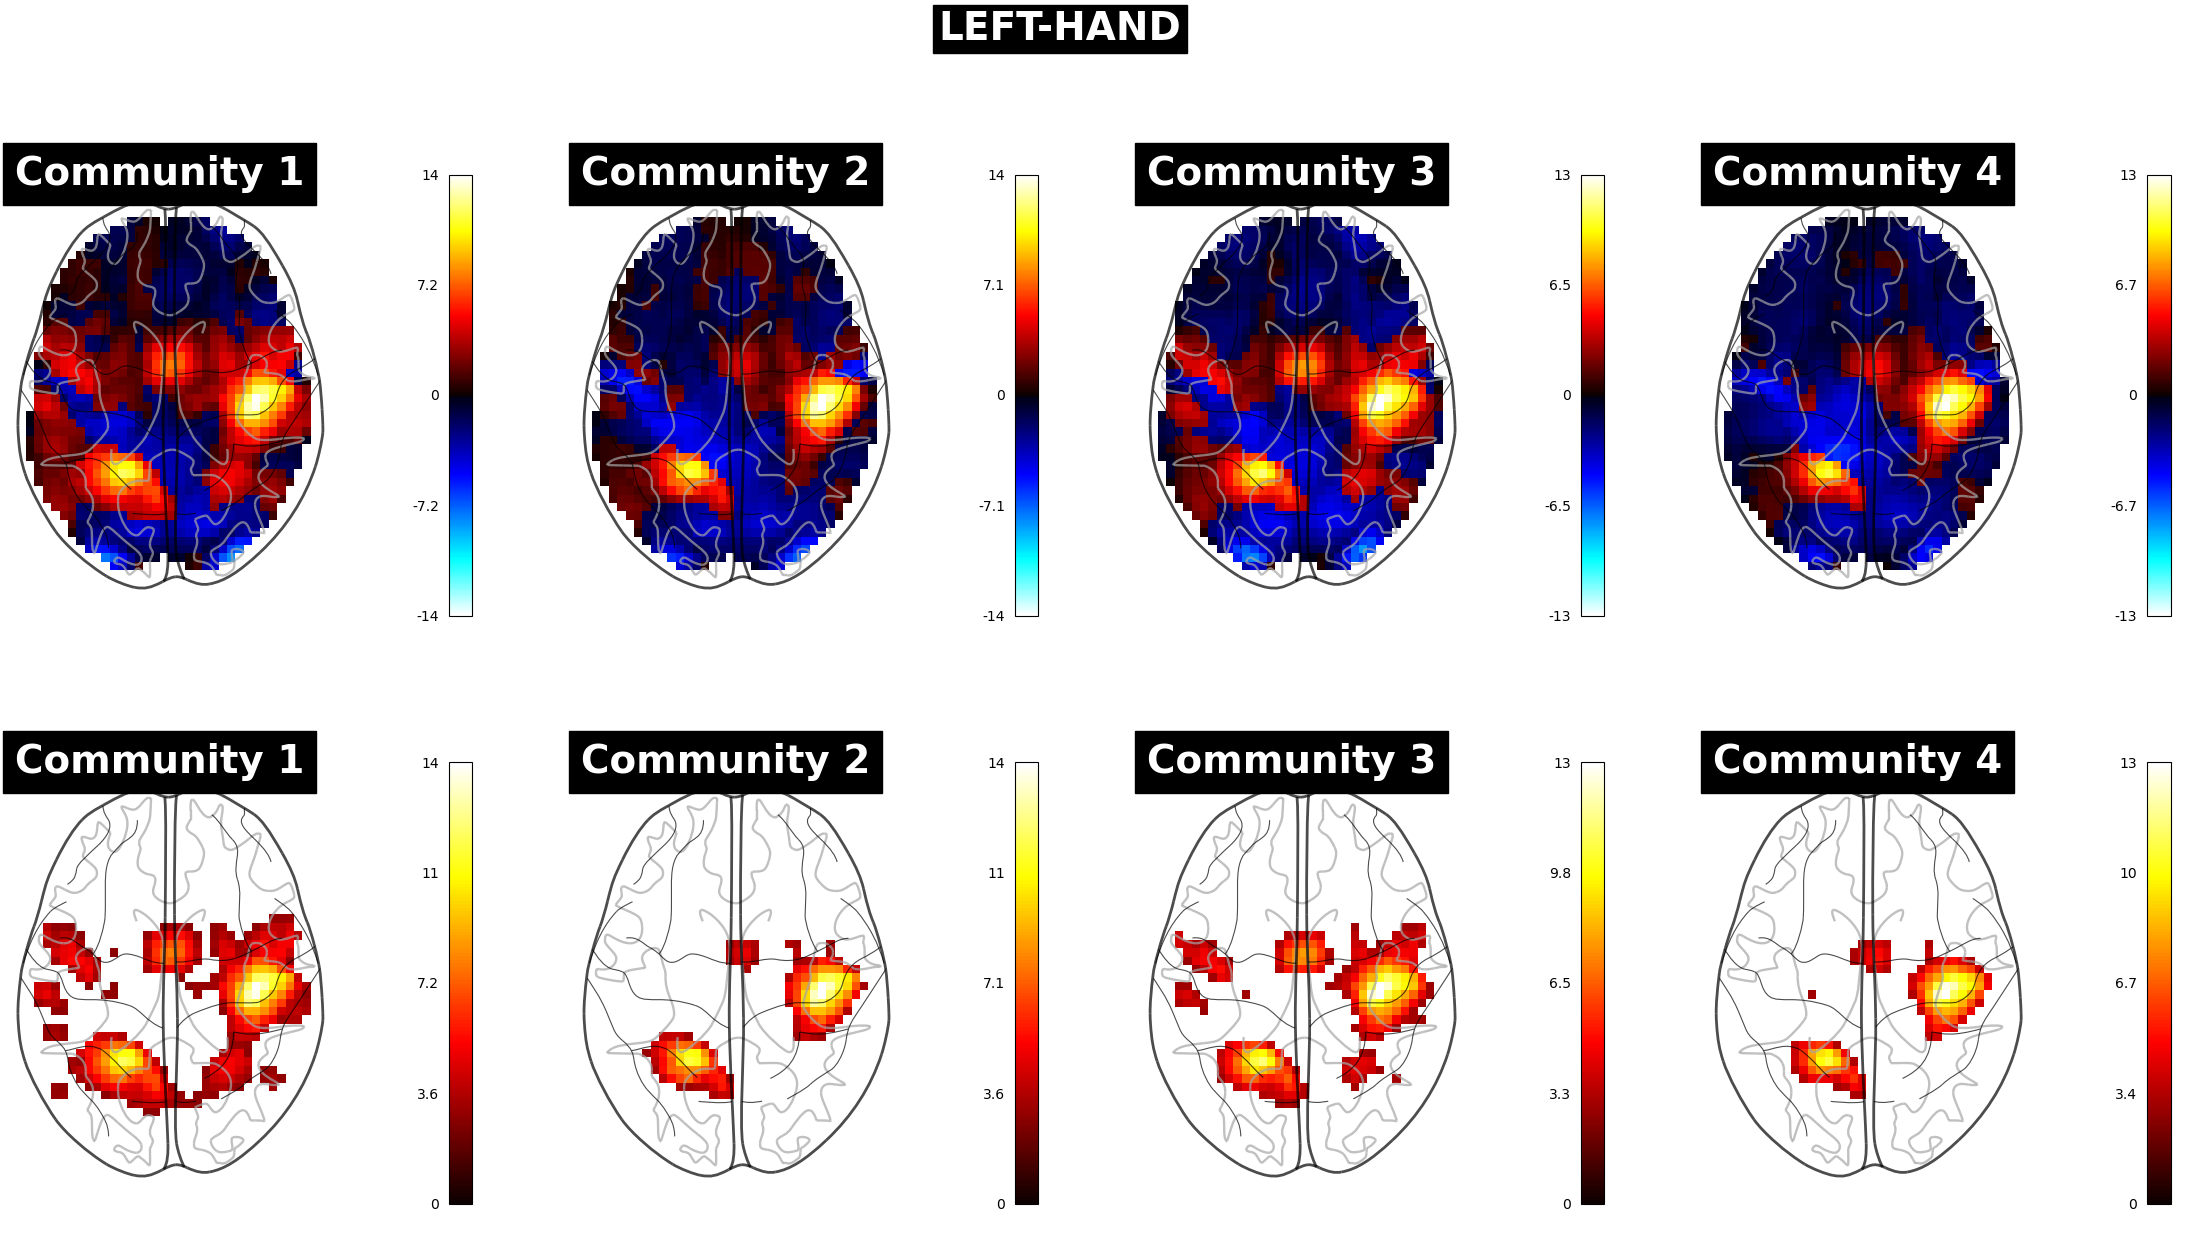

In [2]:
import mean_maps
mean_maps.main()

In [1]:
import pickle 
from glob import glob 

Qs = []

for i,f in enumerate(glob('../figures/corr_matrix*group*')):
    print(f)
    with open(f, "rb") as fp:   #Pickling
        Qs.append(pickle.load(fp))

../figures/corr_matrix_1000_groups_left-foot
../figures/corr_matrix_1000_groups_left-hand
../figures/corr_matrix_1000_groups_right-foot
../figures/corr_matrix_1000_groups_right-hand
../figures/corr_matrix_1000_groups_t


In [2]:
import itertools
Qs_unchain = list(itertools.chain(*Qs))
len(list(Qs_unchain))

5000

In [3]:
import networkx as nx
from community import community_louvain
import numpy as np

def per_group_partitioning(Qs):
    # Compute per group
    partitioning = {}
    groupnums = [i for i in range(5000)]

    for i,group in enumerate(groupnums):
        correlation_matrix = Qs[i]
        G = nx.Graph(np.abs(correlation_matrix))  # must be positive value for graphing
        partition = community_louvain.best_partition(G, random_state=0)
        partitioning['{}_partition'.format(group)] = [partition, G, correlation_matrix]

    return partitioning

In [4]:
partitioning = per_group_partitioning(Qs_unchain)

In [5]:
len(partitioning)

5000

In [6]:
def compute_partition_matrix(data_path, partitioning):
    data_fpath = sorted(glob(f'{data_path}/group-1_*right-hand_*_tstat.nii*'))
    subject = [img.split('/')[-1].split('_')[2].split('-')[0].upper() +','+img.split('/')[-1].split('_')[2].split('-')[1]+','+img.split('/')[-1].split('_')[2].split('-')[2] +',' + img.split('/')[-1].split('_')[2].split('-')[3] for img in sorted(data_fpath)]

    ##############
    # build a matrix which summarize all hypothese louvain community into one community
    ##############

    matrix_graph = np.zeros((24, 24))
    # teams per partition
    for key_i in partitioning.keys():
        #print('\n***** Doing ****')
        #print(key_i)
        # build summary matrix for alltogether matrix
        for key_j in partitioning[key_i][0].keys():
            community_key_j = partitioning[key_i][0][key_j]
            for team in range(len(partitioning[key_i][0].keys())):
                if team == key_j: # a team should not be counted as belonging to same community of itself
                    continue
                if partitioning[key_i][0][team] == community_key_j:
                    # # debugging
                    #print(partitioning[key_i][0][team], " == ", community_key_j, ' thus adding 1 at row: ', subject[team], " col: ", subject[key_j])
                    matrix_graph[team][key_j] += 1

    return matrix_graph, subject

In [7]:
data_path = '/Volumes/empenn/egermani/hcp_many_pipelines'

matrix_graph, subject = compute_partition_matrix(data_path, partitioning)

In [8]:
G = nx.Graph(matrix_graph, seed=0)
# compute the best partition
partition = community_louvain.best_partition(G, random_state=0)

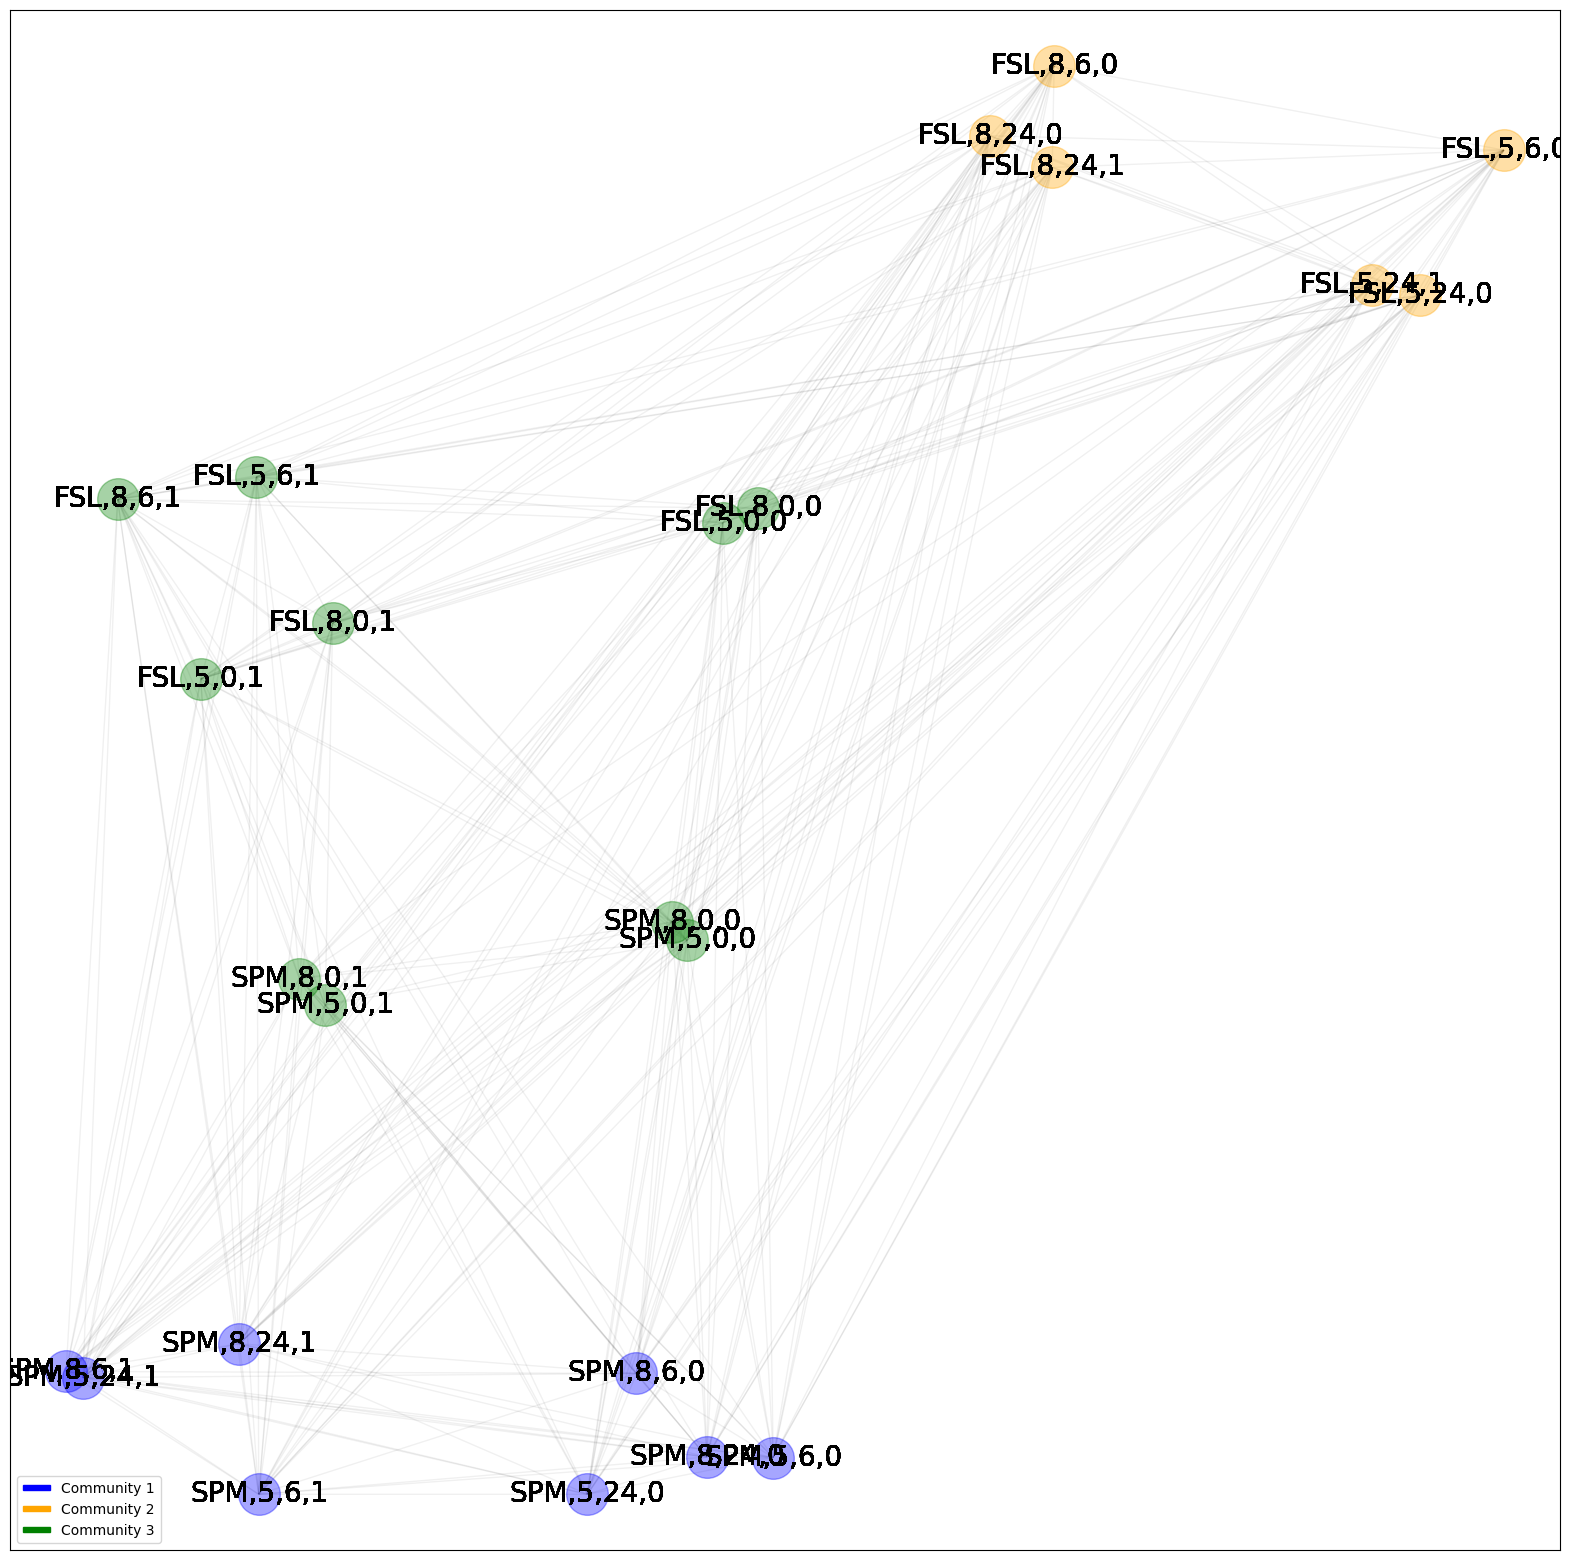

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps
f, axs = plt.subplots(1, 1, figsize=(20, 20)) 
# draw the graph
pos = nx.spring_layout(G, seed=0)
# color the nodes according to their partition
colors = ['blue', 'orange', 'green', 'red', 'darkviolet', 'yellow', "yellowgreen", 'lime', 'crimson', 'aqua']
# draw edges
nx.draw_networkx_edges(G, pos, ax=axs, alpha=0.06)#, min_source_margin=, min_target_margin=)
# useful for labeling nodes
inv_map = {k: subject[k] for k, v in partition.items()}
# draw nodes and labels
for node, color in partition.items():
    nx.draw_networkx_nodes(G, pos, [node], ax=axs, node_size=900,
                           node_color=[colors[color]], margins=-0.01, alpha=0.35)
    # add labels to the nodes
    nx.draw_networkx_labels(G,pos,inv_map, ax=axs, font_size=20, font_color='black')
    
legend_labels = []
for com_nb in range(max(partition.values())+1):
    patch = mpatches.Patch(color=colors[com_nb], label='Community {}'.format(com_nb+1))
    legend_labels.append(patch)
axs.legend(handles=legend_labels, loc='lower left', handleheight=0.2)

In [10]:
import pandas as pd
def reorganize_with_louvain_community(matrix, partition):
    ''' Reorganized the correlation matrix according to the partition

    Parameters
    ----------
    matrix : correlation matrix (n_roi*n_roi)

    Returns
    ----------
    Dataframe reorganized as louvain community 
    '''
    # compute the best partition
    louvain = np.zeros(matrix.shape).astype(matrix.dtype)
    labels = range(len(matrix))
    labels_new_order = []
    
    # reorganize matrix row-wise
    i = 0
    # iterate through all created community
    for values in np.unique(list(partition.values())):
        # iterate through each ROI
        for key in partition:
            if partition[key] == values:
                louvain[i] = matrix[key]
                labels_new_order.append(labels[key])
                i += 1

    # checking change in positionning from original matrix to louvain matrix
    # get index of first roi linked to community 0
    index_roi_com0_louvain = list(partition.values()).index(0)
    # get nb of roi in community 0
    nb_com0 = np.unique(list(partition.values()), return_counts=True)[1][0]
    # # get index of first roi linked to community 1
    index_roi_com1_louvain = list(partition.values()).index(1)
    assert louvain[0].sum() == matrix[index_roi_com0_louvain].sum()
    assert louvain[nb_com0].sum() == matrix[index_roi_com1_louvain].sum() 

    df_louvain = pd.DataFrame(index=labels_new_order, columns=labels, data=louvain)

    # reorganize matrix column-wise
    df_louvain = df_louvain[df_louvain.index]
    return df_louvain

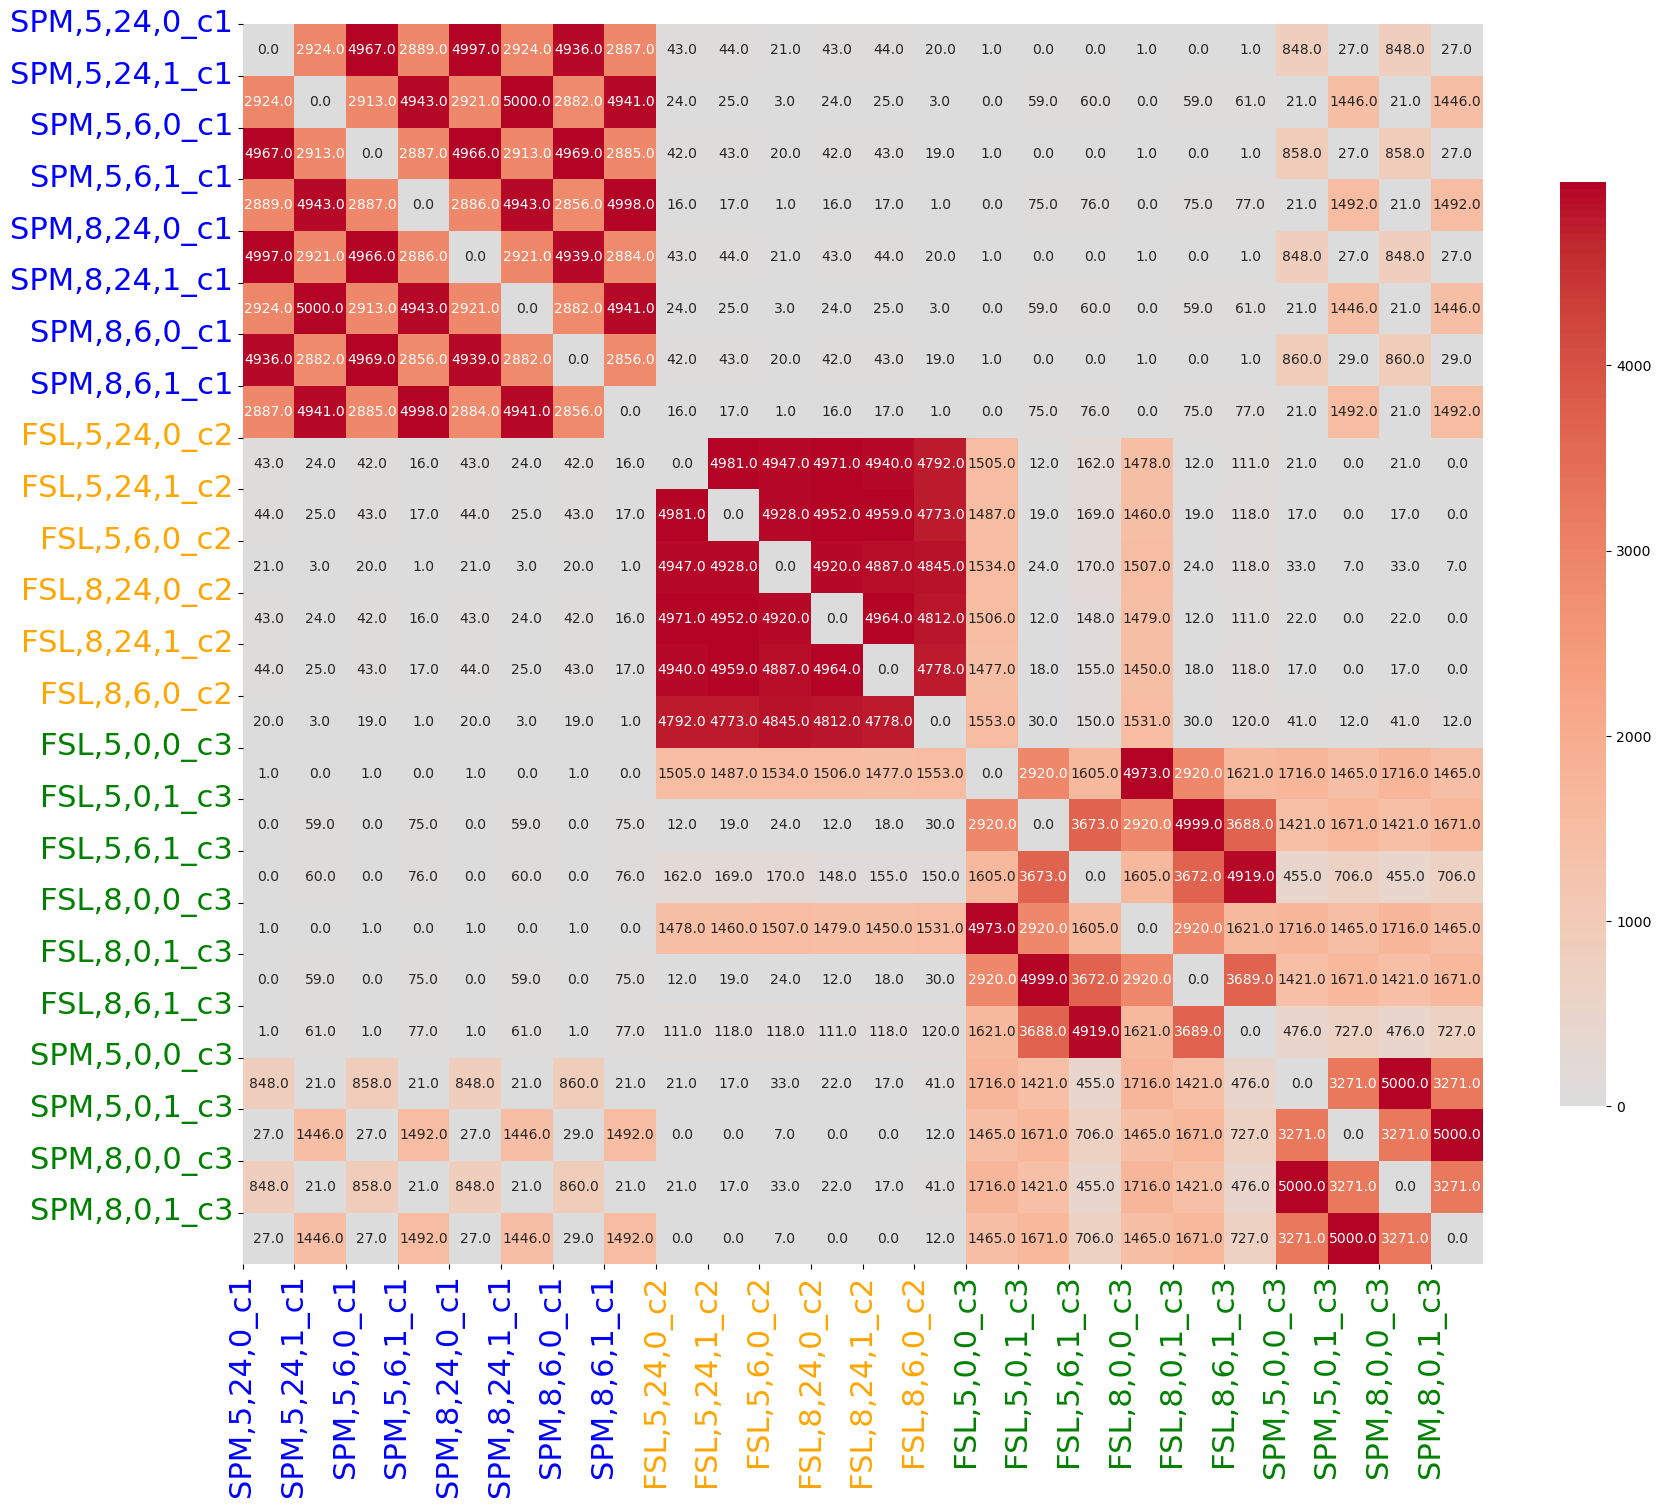

In [14]:
import seaborn
import importlib 
#importlib.reload(matplotlib)
f, axs = plt.subplots(1, 1, figsize=(20, 20)) 
# draw heatmap
matrix_organized_louvain = reorganize_with_louvain_community(matrix_graph, partition)
labs = np.array(matrix_organized_louvain).astype('str')
labels = [subject[louvain_index] + "_c{}".format(partition[louvain_index]+1) for louvain_index in matrix_organized_louvain.columns]
cm = seaborn.heatmap(matrix_organized_louvain, center=0, cmap='coolwarm', robust=True, square=True, ax=axs,
                     cbar_kws={'shrink': 0.6}, xticklabels=False, annot=labs, fmt='')
#axs[1].set_title(title_heatmap, fontsize=16)
N_team = matrix_organized_louvain.columns.__len__()
axs.set_xticks(range(N_team), labels=labels, rotation=90, fontsize=22)
axs.set_yticks(range(N_team), labels=labels, rotation=360, fontsize=22)

for i, ticklabel in enumerate(cm.axes.yaxis.get_majorticklabels()):
    color_tick = colors[int(ticklabel.get_text()[-1])-1]
    ticklabel.set_color(color_tick)
    
for i, ticklabel in enumerate(cm.axes.xaxis.get_majorticklabels()):
    color_tick = colors[int(ticklabel.get_text()[-1])-1]
    ticklabel.set_color(color_tick)